In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from ultralytics import YOLO
import numpy as np
import cv2
from pathlib import Path
import yaml
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4060 Ti


## 1. Load Dataset with Severity Labels

In [2]:
class PotholeDatasetWithSeverity(Dataset):
    """Dataset loader for pothole detection with severity labels.
    
    Label format: class_id x_center y_center width height severity
    """
    
    def __init__(self, images_dir, labels_dir, img_size=640, augment=False):
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        self.img_size = img_size
        self.augment = augment
        
        # Get all image files
        self.image_files = sorted(list(self.images_dir.glob('*.jpg')))
        print(f"Found {len(self.image_files)} images in {images_dir}")
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_files[idx]
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]
        
        # Load labels
        label_path = self.labels_dir / f"{img_path.stem}.txt"
        
        boxes = []
        severities = []
        
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 6:  # class x y w h severity
                        cls, x, y, bw, bh, sev = map(float, parts)
                        boxes.append([x, y, bw, bh])
                        severities.append(int(sev))
        
        # Resize image
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)  # HWC -> CHW
        
        # Convert to tensors
        if len(boxes) > 0:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            severities = torch.tensor(severities, dtype=torch.long)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            severities = torch.zeros((0,), dtype=torch.long)
        
        return {
            'image': image,
            'boxes': boxes,
            'severities': severities,
            'img_path': str(img_path)
        }

# Test dataset loading
train_dataset = PotholeDatasetWithSeverity(
    images_dir='train/images',
    labels_dir='severity_labels/train/labels',
    img_size=640
)

# Show sample
sample = train_dataset[0]
print(f"\nSample data:")
print(f"Image shape: {sample['image'].shape}")
print(f"Number of boxes: {len(sample['boxes'])}")
print(f"Severities: {sample['severities'].tolist()}")

Found 1502 images in train/images

Sample data:
Image shape: torch.Size([3, 640, 640])
Number of boxes: 5
Severities: [0, 2, 0, 0, 0]


In [3]:
class SeverityClassificationHead(nn.Module):
    """Severity classification head that processes RoI features.
    
    Takes features from detected boxes and classifies severity.
    """
    
    def __init__(self, in_channels=128, num_classes=3, roi_size=7):
        super().__init__()
        self.roi_size = roi_size
        self.num_classes = num_classes
        
        # Feature extraction for RoI
        self.conv1 = nn.Conv2d(in_channels, 128, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Global average pooling + classification
        self.fc1 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(32, num_classes)
        
    def forward(self, features, boxes):
        """Forward pass.
        
        Args:
            features: Feature map from backbone [B, C, H, W]
            boxes: Normalized bounding boxes [N, 4] (x, y, w, h)
            
        Returns:
            severity_logits: Classification logits [N, num_classes]
        """
        if len(boxes) == 0:
            return torch.zeros((0, self.num_classes), device=features.device)
        
        # Extract RoI features using RoI pooling approximation
        roi_features = self.extract_roi_features(features, boxes)
        
        # Process RoI features
        x = F.relu(self.bn1(self.conv1(roi_features)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        # Global average pooling
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.flatten(1)
        
        # Classification
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def extract_roi_features(self, features, boxes):
        """Extract RoI features from feature map.
        
        Args:
            features: Feature map [1, C, H, W] for a single image
            boxes: Boxes for this image [N, 4]
        """
        _, channels, feat_h, feat_w = features.shape
        roi_features_list = []
        
        for box in boxes:
            # Convert normalized box to feature map coordinates
            # Extract scalar values from tensor - handle both 1D and 0D tensors
            if isinstance(box, torch.Tensor):
                box_vals = box.flatten().tolist()
                x_center, y_center, w, h = box_vals[0], box_vals[1], box_vals[2], box_vals[3]
            else:
                x_center, y_center, w, h = box
            
            x1 = int((x_center - w/2) * feat_w)
            y1 = int((y_center - h/2) * feat_h)
            x2 = int((x_center + w/2) * feat_w)
            y2 = int((y_center + h/2) * feat_h)
            
            # Clamp to feature map bounds
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(feat_w, x2), min(feat_h, y2)
            
            # Extract and resize RoI
            if x2 > x1 and y2 > y1:
                roi = features[:, :, y1:y2, x1:x2]
                roi = F.interpolate(roi, size=(self.roi_size, self.roi_size), 
                                   mode='bilinear', align_corners=False)
            else:
                roi = torch.zeros((1, channels, self.roi_size, self.roi_size),
                                device=features.device)
            
            roi_features_list.append(roi)
        
        # Stack all RoIs
        roi_features = torch.cat(roi_features_list, dim=0)
        return roi_features

print("Severity classification head defined")

Severity classification head defined


In [4]:
class MultiTaskPotholeDetector(nn.Module):
    """Multi-task model combining YOLO11n detection with severity classification."""
    
    def __init__(self, yolo_model_path='yolo11n.pt', num_severity_classes=3):
        super().__init__()
        
        # Load YOLO11n for detection
        self.yolo = YOLO(yolo_model_path)
        
        # Add severity classification head
        # YOLO11n backbone outputs features at different scales
        # We'll use layer 6 features (40x40 @ 128 channels)
        self.severity_head = SeverityClassificationHead(
            in_channels=128,
            num_classes=num_severity_classes
        )
        
    def forward(self, images, boxes=None, mode='train'):
        """
        Args:
            images: Input images [B, 3, H, W]
            boxes: List of boxes per image, each [N_i, 4]
            mode: 'train' or 'eval'
            
        Returns:
            detection_results: YOLO detection outputs
            severity_logits: Severity classification logits
        """
        # Get YOLO detection results
        if mode == 'train':
            # During training, we use ground truth boxes for severity classification
            # (teacher forcing to stabilize training)
            detection_results = None  # YOLO handles its own loss internally
            
            # Get backbone features for severity classification
            # Process each image separately since boxes are per-image
            all_severity_logits = []
            
            for i in range(len(images)):
                img_features = self.extract_features(images[i:i+1])
                img_boxes = boxes[i] if boxes is not None and i < len(boxes) else []
                
                if len(img_boxes) > 0:
                    img_severity_logits = self.severity_head(img_features, img_boxes)
                    all_severity_logits.append(img_severity_logits)
            
            if len(all_severity_logits) > 0:
                severity_logits = torch.cat(all_severity_logits, dim=0)
            else:
                severity_logits = torch.zeros((0, 3), device=images.device)
                
        else:
            # During inference, use detected boxes
            detection_results = self.yolo(images, verbose=False)
            features = self.extract_features(images)
            
            # Extract boxes from detection results
            detected_boxes = self.get_boxes_from_results(detection_results)
            
            if len(detected_boxes) > 0:
                severity_logits = self.severity_head(features, detected_boxes)
            else:
                severity_logits = torch.zeros((0, 3), device=images.device)
        
        return detection_results, severity_logits
    
    def extract_features(self, images):
        """Extract feature map from YOLO backbone."""
        # This is a simplified version - we'll access YOLO's backbone
        model = self.yolo.model
        
        # Forward through backbone to get features
        # YOLO11n has multiple feature levels, we use P4 (80x80 resolution)
        x = images
        
        # Get features from backbone (before detection head)
        features = []
        for i, m in enumerate(model.model[:10]):  # First 10 layers are backbone
            x = m(x)
            if i == 6:  # P4 features at layer 6
                features.append(x)
        
        return features[0] if features else x
    
    def get_boxes_from_results(self, results):
        """Extract normalized boxes from YOLO results."""
        boxes = []
        for result in results:
            if result.boxes is not None and len(result.boxes) > 0:
                # Get boxes in xywh normalized format
                xywhn = result.boxes.xywhn.cpu()  # [N, 4] tensor
                for i in range(len(xywhn)):
                    boxes.append(xywhn[i])
        
        if len(boxes) > 0:
            boxes_tensor = torch.stack(boxes)
            if results[0].boxes is not None:
                boxes_tensor = boxes_tensor.to(results[0].boxes.data.device)
            return boxes_tensor
        return torch.zeros((0, 4), dtype=torch.float32)

print("Multi-task model architecture defined")

Multi-task model architecture defined


## 3. Training Strategy

**Two-Stage Training Approach**:

### Stage 1: Use Pre-trained Ghost YOLO11n
- **Skip training!** Use already trained Ghost YOLO11n from `runs/detect/yolo11_ghost_pothole3/`
- Ghost model achieved: mAP@0.5 = 90.95%
- This saves ~2-3 hours of GPU time!

### Stage 2: Train Severity Head Only
- Freeze Ghost YOLO backbone and detection head
- Train only severity classification head
- Use ground truth boxes for RoI extraction

**Efficiency Benefits:**
- No need to retrain detection (already have Ghost model)
- Severity head training: ~30 minutes
- Total multi-task model: Lightweight + accurate

## Stage 1: Use Pre-trained Ghost YOLO11n

We'll use the already trained Ghost YOLO11n model from `runs/detect/yolo11_ghost_pothole3/`.

In [5]:
# Load pre-trained Ghost YOLO11n
from pathlib import Path
import re

# Use the pre-trained Ghost model
ghost_model_path = 'runs/detect/yolo11_ghost_pothole3/weights/best.pt'

if not Path(ghost_model_path).exists():
    raise FileNotFoundError(f"Ghost model not found at {ghost_model_path}. Please train it first using ghost_model_train.ipynb")

# Load model to verify it works
model = YOLO(ghost_model_path)
print(f"✓ Loaded pre-trained Ghost YOLO11n from: {ghost_model_path}")

# Validate to show current performance
print("\nValidating Ghost YOLO11n on validation set...")
val_metrics = model.val(data='data.yaml', split='val', verbose=False)
print(f"  mAP@0.5: {val_metrics.box.map50:.4f}")
print(f"  mAP@0.5:0.95: {val_metrics.box.map:.4f}")
print(f"  Precision: {val_metrics.box.mp:.4f}")
print(f"  Recall: {val_metrics.box.mr:.4f}")

# Get version for this run
def get_next_run_version(base_name='ghost_multitask_severity'):
    """Find next version number for complete experiment runs."""
    runs_dir = Path('runs/detect')
    if not runs_dir.exists():
        return 1
    
    pattern = re.compile(rf'(\d+)_{re.escape(base_name)}')
    versions = []
    
    for d in runs_dir.iterdir():
        if d.is_dir():
            match = pattern.match(d.name)
            if match:
                versions.append(int(match.group(1)))
    
    return max(versions) + 1 if versions else 1

run_version = get_next_run_version('ghost_multitask_severity')
detection_model_name = f'{run_version:02d}_ghost_multitask_severity'
detection_model_path = Path(f'runs/detect/{detection_model_name}')
detection_model_path.mkdir(parents=True, exist_ok=True)

print(f"\n🆕 Creating new run: {detection_model_name}")
print(f"📁 Directory: {detection_model_path}")
print(f"\n✓ Stage 1 Complete: Using pre-trained Ghost YOLO11n")
print(f"  Detection mAP@0.5: {val_metrics.box.map50:.4f}")

✓ Loaded pre-trained Ghost YOLO11n from: runs/detect/yolo11_ghost_pothole3/weights/best.pt

Validating Ghost YOLO11n on validation set...
Ultralytics 8.3.217  Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16380MiB)
YOLO11n_ghost summary (fused): 141 layers, 2,031,827 parameters, 0 gradients, 6.0 GFLOPs
YOLO11n_ghost summary (fused): 141 layers, 2,031,827 parameters, 0 gradients, 6.0 GFLOPs
YOLO11n_ghost summary (fused): 141 layers, 2,031,827 parameters, 0 gradients, 6.0 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 926.4262.1 MB/s, size: 37.9 KB)
val: Scanning D:\COS40007\pothole_detection\valid\labels.cache... 429 images, 27 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 429/429  0.0sval: Fast image access  (ping: 0.00.0 ms, read: 926.4262.1 MB/s, size: 37.9 KB)
val: Scanning D:\COS40007\pothole_detection\valid\labels.cache... 429 images, 27 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 429/429  0.0sval: Fast image access  (ping: 0.00.0 ms, read: 926.4262.1 MB/s

In [6]:
# Validate Stage 1 model (already done above)
print("\n✓ Ghost YOLO11n validation complete")
print(f"  Model: {ghost_model_path}")
print(f"  mAP@0.5: {val_metrics.box.map50:.4f}")
print(f"  Ready for Stage 2: Severity classification training")

# For comparison tracking
baseline_map = 0.7712
ghost_map = val_metrics.box.map50
print(f"\nComparison to baseline:")
print(f"  Baseline YOLO11n: {baseline_map:.4f}")
print(f"  Ghost YOLO11n: {ghost_map:.4f}")
print(f"  Improvement: {(ghost_map - baseline_map)/baseline_map*100:+.2f}%")


✓ Ghost YOLO11n validation complete
  Model: runs/detect/yolo11_ghost_pothole3/weights/best.pt
  mAP@0.5: 0.9125
  Ready for Stage 2: Severity classification training

Comparison to baseline:
  Baseline YOLO11n: 0.7712
  Ghost YOLO11n: 0.9125
  Improvement: +18.32%


In [7]:
# Validate Stage 1 model (save in run directory)
print("\nValidating detection model on validation set...")
val_save_dir = detection_model_path / 'validation'
val_save_dir.mkdir(exist_ok=True)
metrics = model.val(data='data.yaml', project=str(val_save_dir), name='val_results', exist_ok=True)

print(f"\nDetection Performance:")
print(f"  mAP@0.5: {metrics.box.map50:.4f}")
print(f"  mAP@0.5:0.95: {metrics.box.map:.4f}")
print(f"  Precision: {metrics.box.mp:.4f}")
print(f"  Recall: {metrics.box.mr:.4f}")
print(f"  Results saved: {val_save_dir / 'val_results'}")

# Compare to baseline
baseline_map = 0.7712
improvement = (metrics.box.map50 - baseline_map) / baseline_map * 100
print(f"\nBaseline comparison:")
print(f"  Baseline mAP@0.5: {baseline_map:.4f}")
print(f"  Current mAP@0.5: {metrics.box.map50:.4f}")
print(f"  Improvement: {improvement:+.2f}%")


Validating detection model on validation set...
Ultralytics 8.3.217  Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16380MiB)
val: Fast image access  (ping: 0.00.0 ms, read: 1333.7999.6 MB/s, size: 70.1 KB)
val: Fast image access  (ping: 0.00.0 ms, read: 1333.7999.6 MB/s, size: 70.1 KB)
val: Fast image access  (ping: 0.00.0 ms, read: 1333.7999.6 MB/s, size: 70.1 KB)
val: Scanning D:\COS40007\pothole_detection\valid\labels.cache... 429 images, 27 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 429/429 96.3Kit/s 0.0s
val: Scanning D:\COS40007\pothole_detection\valid\labels.cache... 429 images, 27 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 429/429 96.3Kit/s 0.0s
val: Scanning D:\COS40007\pothole_detection\valid\labels.cache... 429 images, 27 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 429/429 96.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 7.3it/s 3.7s0.1s
                 Class     Images  Inst

In [8]:
# Custom collate function for variable-sized boxes
def collate_fn(batch):
    """Collate function that handles variable-sized boxes."""
    images = torch.stack([item['image'] for item in batch])
    boxes = [item['boxes'] for item in batch]  # Keep as list
    severities = [item['severities'] for item in batch]  # Keep as list
    img_paths = [item['img_path'] for item in batch]
    
    return {
        'image': images,
        'boxes': boxes,
        'severities': severities,
        'img_path': img_paths
    }

# Create data loaders
train_dataset = PotholeDatasetWithSeverity(
    images_dir='train/images',
    labels_dir='severity_labels/train/labels',
    img_size=640
)

val_dataset = PotholeDatasetWithSeverity(
    images_dir='valid/images',
    labels_dir='severity_labels/valid/labels',
    img_size=640
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Found 1502 images in train/images
Found 429 images in valid/images
Train batches: 188
Val batches: 54


## Stage 2: Train Severity Classification Head

In [10]:
# Stage 2: Train Severity Classification
severity_save_path = detection_model_path / 'severity_head_best.pt'
print(f"Severity head will be saved to: {severity_save_path}")

# Create multi-task model with Ghost YOLO11n
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
multitask_model = MultiTaskPotholeDetector(
    yolo_model_path=ghost_model_path,
    num_severity_classes=3
).to(device)

# Freeze Ghost YOLO backbone and detection head
for param in multitask_model.yolo.model.parameters():
    param.requires_grad = False

print("\n✓ Frozen Ghost YOLO detection model")
print("✓ Training only severity classification head")

# Count trainable parameters
trainable_params = sum(p.numel() for p in multitask_model.severity_head.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in multitask_model.parameters())
ghost_yolo_params = sum(p.numel() for p in multitask_model.yolo.model.parameters())

print(f"\n📊 Model Statistics:")
print(f"  Ghost YOLO params: {ghost_yolo_params:,}")
print(f"  Severity head params: {trainable_params:,}")
print(f"  Total params: {total_params:,}")
print(f"  Trainable: {trainable_params/total_params*100:.2f}%")

Severity head will be saved to: runs\detect\02_ghost_multitask_severity\severity_head_best.pt

✓ Frozen Ghost YOLO detection model
✓ Training only severity classification head

📊 Model Statistics:
  Ghost YOLO params: 2,038,243
  Severity head params: 223,939
  Total params: 2,262,182
  Trainable: 9.90%


In [20]:
# Display model architecture summary

print("MODEL ARCHITECTURE SUMMARY")


print("\n📋 GHOST YOLO11n BACKBONE:")

print(f"{'Layer':<40} {'Type':<25} {'Parameters':>20}")


# Show only top-level YOLO model layers (main structure)
for i, m in enumerate(multitask_model.yolo.model.model):
    params = sum(p.numel() for p in m.parameters())
    layer_type = m.__class__.__name__
    print(f"Layer {i:<34} {layer_type:<25} {params:>20,}")

yolo_total = sum(p.numel() for p in multitask_model.yolo.model.parameters())

print(f"{'BACKBONE TOTAL':<40} {'':<25} {yolo_total:>20,}")

print("\n📋 SEVERITY CLASSIFICATION HEAD:")

print(f"{'Layer':<40} {'Type':<25} {'Parameters':>20}")


# Show severity head structure
layers = [
    ('conv1', multitask_model.severity_head.conv1),
    ('bn1', multitask_model.severity_head.bn1),
    ('conv2', multitask_model.severity_head.conv2),
    ('bn2', multitask_model.severity_head.bn2),
    ('fc1', multitask_model.severity_head.fc1),
    ('dropout', multitask_model.severity_head.dropout),
    ('fc2', multitask_model.severity_head.fc2)
]

severity_total = 0
for name, layer in layers:
    params = sum(p.numel() for p in layer.parameters())
    severity_total += params
    layer_type = layer.__class__.__name__
    status = " Trainable" if params > 0 else ""
    print(f"{name:<40} {layer_type:<25} {params:>20,} {status}")

print("-"*90)
print(f"{'SEVERITY HEAD TOTAL':<40} {'':<25} {severity_total:>20,}")

print("📊 FINAL SUMMARY")

print(f"Ghost YOLO11n Backbone:      {yolo_total:>20,} params (Frozen)")
print(f"Severity Classification:     {severity_total:>20,} params (Trainable)")

print(f"Total Parameters:            {total_params:>20,}")
print(f"Trainable:                   {trainable_params:>20,} ({trainable_params/total_params*100:.2f}%)")
print(f"Frozen:                      {yolo_total:>20,} ({yolo_total/total_params*100:.2f}%)")


MODEL ARCHITECTURE SUMMARY

📋 GHOST YOLO11n BACKBONE:
Layer                                    Type                                Parameters
Layer 0                                  Conv                                       464
Layer 1                                  GhostConv                                2,768
Layer 2                                  C3Ghost                                  7,608
Layer 3                                  GhostConv                               19,360
Layer 4                                  C3Ghost                                 28,528
Layer 5                                  GhostConv                               75,584
Layer 6                                  C3Ghost                                 36,720
Layer 7                                  GhostConv                              151,168
Layer 8                                  C3Ghost                                143,072
Layer 9                                  SPPF                     

In [11]:
# Training setup for severity head
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(multitask_model.severity_head.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

num_epochs = 50
best_val_acc = 0.0
best_epoch = 0

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("\nStage 2: Training Severity Classification Head")
print("="*60)


Stage 2: Training Severity Classification Head


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 60)
    
    # Training phase
    # Set training flags directly to avoid YOLO's overridden train()/eval() methods
    multitask_model.training = False
    multitask_model.yolo.model.training = False
    multitask_model.severity_head.training = True
    
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for batch in pbar:
        images = batch['image'].to(device)
        boxes = batch['boxes']
        severities = batch['severities']
        
        # Move boxes to device and concatenate severities for loss computation
        boxes_device = [b.to(device) if len(b) > 0 else b for b in boxes]
        all_severities = torch.cat([s for s in severities if len(s) > 0], dim=0).to(device)
        
        if len(all_severities) == 0:
            continue
        
        # Forward pass - pass boxes as list per image
        optimizer.zero_grad()
        _, severity_logits = multitask_model(images, boxes=boxes_device, mode='train')
        
        # Compute loss
        loss = criterion(severity_logits, all_severities)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item() * len(all_severities)
        _, predicted = torch.max(severity_logits, 1)
        train_correct += (predicted == all_severities).sum().item()
        train_total += len(all_severities)
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 
                         'acc': f'{train_correct/train_total:.4f}'})
    
    train_loss /= train_total
    train_acc = train_correct / train_total
    
    # Validation phase
    multitask_model.training = False
    multitask_model.yolo.model.training = False
    multitask_model.severity_head.training = False
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for batch in pbar:
            images = batch['image'].to(device)
            boxes = batch['boxes']
            severities = batch['severities']
            
            # Move boxes to device and concatenate severities for loss computation
            boxes_device = [b.to(device) if len(b) > 0 else b for b in boxes]
            all_severities = torch.cat([s for s in severities if len(s) > 0], dim=0).to(device)
            
            if len(all_severities) == 0:
                continue
            
            # Forward pass - pass boxes as list per image
            _, severity_logits = multitask_model(images, boxes=boxes_device, mode='train')
            
            # Compute loss
            loss = criterion(severity_logits, all_severities)
            
            # Statistics
            val_loss += loss.item() * len(all_severities)
            _, predicted = torch.max(severity_logits, 1)
            val_correct += (predicted == all_severities).sum().item()
            val_total += len(all_severities)
            
            # Per-class accuracy
            for i in range(len(all_severities)):
                label = all_severities[i].item()
                class_total[label] += 1
                if predicted[i] == label:
                    class_correct[label] += 1
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 
                             'acc': f'{val_correct/val_total:.4f}'})
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    print(f"\n  Per-class Accuracy:")
    severity_names = {0: 'Minor', 1: 'Moderate', 2: 'Severe'}
    for cls_id in sorted(class_total.keys()):
        acc = class_correct[cls_id] / class_total[cls_id] if class_total[cls_id] > 0 else 0
        print(f"    {severity_names[cls_id]:10}: {acc:.4f} ({class_correct[cls_id]}/{class_total[cls_id]})")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save(multitask_model.severity_head.state_dict(), severity_save_path)
        print(f"  ✓ New best model saved! (Val Acc: {val_acc:.4f})")

print("\n" + "="*60)
print("Stage 2 Training Complete!")
print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
print("="*60)


Epoch 1/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:12<00:00,  4.32it/s, loss=1.0824, acc=0.7564]



Epoch 1 Summary:
  Train Loss: 0.6843 | Train Acc: 0.7089
  Val Loss: 0.5645 | Val Acc: 0.7564

  Per-class Accuracy:
    Minor     : 0.8777 (725/826)
    Moderate  : 0.7994 (259/324)
    Severe    : 0.0774 (13/168)
  ✓ New best model saved! (Val Acc: 0.7564)

Epoch 2/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  6.75it/s, loss=0.9083, acc=0.8209]



Epoch 2 Summary:
  Train Loss: 0.4687 | Train Acc: 0.7946
  Val Loss: 0.4064 | Val Acc: 0.8209

  Per-class Accuracy:
    Minor     : 0.9346 (772/826)
    Moderate  : 0.7253 (235/324)
    Severe    : 0.4464 (75/168)
  ✓ New best model saved! (Val Acc: 0.8209)

Epoch 3/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.23it/s, loss=0.4680, acc=0.8687]



Epoch 3 Summary:
  Train Loss: 0.3474 | Train Acc: 0.8554
  Val Loss: 0.3302 | Val Acc: 0.8687

  Per-class Accuracy:
    Minor     : 0.9431 (779/826)
    Moderate  : 0.7562 (245/324)
    Severe    : 0.7202 (121/168)
  ✓ New best model saved! (Val Acc: 0.8687)

Epoch 4/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.53it/s, loss=0.5535, acc=0.8877]



Epoch 4 Summary:
  Train Loss: 0.2719 | Train Acc: 0.8944
  Val Loss: 0.2958 | Val Acc: 0.8877

  Per-class Accuracy:
    Minor     : 0.9600 (793/826)
    Moderate  : 0.7778 (252/324)
    Severe    : 0.7440 (125/168)
  ✓ New best model saved! (Val Acc: 0.8877)

Epoch 5/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.43it/s, loss=0.5003, acc=0.8953]



Epoch 5 Summary:
  Train Loss: 0.2265 | Train Acc: 0.9153
  Val Loss: 0.2718 | Val Acc: 0.8953

  Per-class Accuracy:
    Minor     : 0.9552 (789/826)
    Moderate  : 0.8117 (263/324)
    Severe    : 0.7619 (128/168)
  ✓ New best model saved! (Val Acc: 0.8953)

Epoch 6/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.59it/s, loss=0.3502, acc=0.9074]



Epoch 6 Summary:
  Train Loss: 0.1908 | Train Acc: 0.9329
  Val Loss: 0.2620 | Val Acc: 0.9074

  Per-class Accuracy:
    Minor     : 0.9625 (795/826)
    Moderate  : 0.7809 (253/324)
    Severe    : 0.8810 (148/168)
  ✓ New best model saved! (Val Acc: 0.9074)

Epoch 7/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.31it/s, loss=0.5916, acc=0.9173]



Epoch 7 Summary:
  Train Loss: 0.1523 | Train Acc: 0.9507
  Val Loss: 0.2178 | Val Acc: 0.9173

  Per-class Accuracy:
    Minor     : 0.9407 (777/826)
    Moderate  : 0.8858 (287/324)
    Severe    : 0.8631 (145/168)
  ✓ New best model saved! (Val Acc: 0.9173)

Epoch 8/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:10<00:00,  5.00it/s, loss=0.2614, acc=0.9143]



Epoch 8 Summary:
  Train Loss: 0.1349 | Train Acc: 0.9593
  Val Loss: 0.2385 | Val Acc: 0.9143

  Per-class Accuracy:
    Minor     : 0.9516 (786/826)
    Moderate  : 0.8056 (261/324)
    Severe    : 0.9405 (158/168)

Epoch 9/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:08<00:00,  6.43it/s, loss=0.1576, acc=0.9310]



Epoch 9 Summary:
  Train Loss: 0.1223 | Train Acc: 0.9604
  Val Loss: 0.1994 | Val Acc: 0.9310

  Per-class Accuracy:
    Minor     : 0.9649 (797/826)
    Moderate  : 0.8364 (271/324)
    Severe    : 0.9464 (159/168)
  ✓ New best model saved! (Val Acc: 0.9310)

Epoch 10/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.51it/s, loss=0.1610, acc=0.9287]



Epoch 10 Summary:
  Train Loss: 0.1120 | Train Acc: 0.9665
  Val Loss: 0.2040 | Val Acc: 0.9287

  Per-class Accuracy:
    Minor     : 0.9685 (800/826)
    Moderate  : 0.8333 (270/324)
    Severe    : 0.9167 (154/168)

Epoch 11/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.32it/s, loss=0.3206, acc=0.9325]



Epoch 11 Summary:
  Train Loss: 0.0957 | Train Acc: 0.9684
  Val Loss: 0.1955 | Val Acc: 0.9325

  Per-class Accuracy:
    Minor     : 0.9794 (809/826)
    Moderate  : 0.8364 (271/324)
    Severe    : 0.8869 (149/168)
  ✓ New best model saved! (Val Acc: 0.9325)

Epoch 12/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.46it/s, loss=0.2455, acc=0.9181]



Epoch 12 Summary:
  Train Loss: 0.0914 | Train Acc: 0.9721
  Val Loss: 0.2121 | Val Acc: 0.9181

  Per-class Accuracy:
    Minor     : 0.9419 (778/826)
    Moderate  : 0.9259 (300/324)
    Severe    : 0.7857 (132/168)

Epoch 13/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.43it/s, loss=0.0774, acc=0.9454]



Epoch 13 Summary:
  Train Loss: 0.0757 | Train Acc: 0.9776
  Val Loss: 0.1756 | Val Acc: 0.9454

  Per-class Accuracy:
    Minor     : 0.9734 (804/826)
    Moderate  : 0.8704 (282/324)
    Severe    : 0.9524 (160/168)
  ✓ New best model saved! (Val Acc: 0.9454)

Epoch 14/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.35it/s, loss=0.1154, acc=0.9492]



Epoch 14 Summary:
  Train Loss: 0.0721 | Train Acc: 0.9792
  Val Loss: 0.1593 | Val Acc: 0.9492

  Per-class Accuracy:
    Minor     : 0.9782 (808/826)
    Moderate  : 0.8642 (280/324)
    Severe    : 0.9702 (163/168)
  ✓ New best model saved! (Val Acc: 0.9492)

Epoch 15/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.57it/s, loss=0.1533, acc=0.9408]



Epoch 15 Summary:
  Train Loss: 0.0609 | Train Acc: 0.9822
  Val Loss: 0.2118 | Val Acc: 0.9408

  Per-class Accuracy:
    Minor     : 0.9600 (793/826)
    Moderate  : 0.9074 (294/324)
    Severe    : 0.9107 (153/168)

Epoch 16/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.04it/s, loss=0.1548, acc=0.9454]



Epoch 16 Summary:
  Train Loss: 0.0712 | Train Acc: 0.9790
  Val Loss: 0.1866 | Val Acc: 0.9454

  Per-class Accuracy:
    Minor     : 0.9746 (805/826)
    Moderate  : 0.8735 (283/324)
    Severe    : 0.9405 (158/168)

Epoch 17/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.40it/s, loss=0.5741, acc=0.9431]



Epoch 17 Summary:
  Train Loss: 0.0541 | Train Acc: 0.9837
  Val Loss: 0.1780 | Val Acc: 0.9431

  Per-class Accuracy:
    Minor     : 0.9709 (802/826)
    Moderate  : 0.9012 (292/324)
    Severe    : 0.8869 (149/168)

Epoch 18/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.43it/s, loss=0.0558, acc=0.9492]



Epoch 18 Summary:
  Train Loss: 0.0487 | Train Acc: 0.9862
  Val Loss: 0.1776 | Val Acc: 0.9492

  Per-class Accuracy:
    Minor     : 0.9709 (802/826)
    Moderate  : 0.8827 (286/324)
    Severe    : 0.9702 (163/168)

Epoch 19/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.41it/s, loss=0.0907, acc=0.9522]



Epoch 19 Summary:
  Train Loss: 0.0528 | Train Acc: 0.9839
  Val Loss: 0.1726 | Val Acc: 0.9522

  Per-class Accuracy:
    Minor     : 0.9588 (792/826)
    Moderate  : 0.9383 (304/324)
    Severe    : 0.9464 (159/168)
  ✓ New best model saved! (Val Acc: 0.9522)

Epoch 20/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.41it/s, loss=0.0542, acc=0.9416]



Epoch 20 Summary:
  Train Loss: 0.0707 | Train Acc: 0.9782
  Val Loss: 0.1903 | Val Acc: 0.9416

  Per-class Accuracy:
    Minor     : 0.9673 (799/826)
    Moderate  : 0.8735 (283/324)
    Severe    : 0.9464 (159/168)

Epoch 21/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.58it/s, loss=0.1700, acc=0.9552]



Epoch 21 Summary:
  Train Loss: 0.0323 | Train Acc: 0.9916
  Val Loss: 0.1820 | Val Acc: 0.9552

  Per-class Accuracy:
    Minor     : 0.9540 (788/826)
    Moderate  : 0.9568 (310/324)
    Severe    : 0.9583 (161/168)
  ✓ New best model saved! (Val Acc: 0.9552)

Epoch 22/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.60it/s, loss=0.0943, acc=0.9628]



Epoch 22 Summary:
  Train Loss: 0.0201 | Train Acc: 0.9962
  Val Loss: 0.1444 | Val Acc: 0.9628

  Per-class Accuracy:
    Minor     : 0.9697 (801/826)
    Moderate  : 0.9475 (307/324)
    Severe    : 0.9583 (161/168)
  ✓ New best model saved! (Val Acc: 0.9628)

Epoch 23/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.53it/s, loss=0.0134, acc=0.9674]



Epoch 23 Summary:
  Train Loss: 0.0131 | Train Acc: 0.9981
  Val Loss: 0.1344 | Val Acc: 0.9674

  Per-class Accuracy:
    Minor     : 0.9831 (812/826)
    Moderate  : 0.9259 (300/324)
    Severe    : 0.9702 (163/168)
  ✓ New best model saved! (Val Acc: 0.9674)

Epoch 24/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.54it/s, loss=0.0771, acc=0.9636]



Epoch 24 Summary:
  Train Loss: 0.0150 | Train Acc: 0.9966
  Val Loss: 0.1516 | Val Acc: 0.9636

  Per-class Accuracy:
    Minor     : 0.9770 (807/826)
    Moderate  : 0.9321 (302/324)
    Severe    : 0.9583 (161/168)

Epoch 25/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  6.89it/s, loss=0.0257, acc=0.9651]



Epoch 25 Summary:
  Train Loss: 0.0169 | Train Acc: 0.9960
  Val Loss: 0.1449 | Val Acc: 0.9651

  Per-class Accuracy:
    Minor     : 0.9782 (808/826)
    Moderate  : 0.9259 (300/324)
    Severe    : 0.9762 (164/168)

Epoch 26/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.48it/s, loss=0.0140, acc=0.9590]



Epoch 26 Summary:
  Train Loss: 0.0123 | Train Acc: 0.9985
  Val Loss: 0.1512 | Val Acc: 0.9590

  Per-class Accuracy:
    Minor     : 0.9758 (806/826)
    Moderate  : 0.9259 (300/324)
    Severe    : 0.9405 (158/168)

Epoch 27/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.51it/s, loss=0.0133, acc=0.9651]



Epoch 27 Summary:
  Train Loss: 0.0087 | Train Acc: 0.9987
  Val Loss: 0.1509 | Val Acc: 0.9651

  Per-class Accuracy:
    Minor     : 0.9746 (805/826)
    Moderate  : 0.9383 (304/324)
    Severe    : 0.9702 (163/168)

Epoch 28/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.58it/s, loss=0.0284, acc=0.9605]



Epoch 28 Summary:
  Train Loss: 0.0191 | Train Acc: 0.9950
  Val Loss: 0.1685 | Val Acc: 0.9605

  Per-class Accuracy:
    Minor     : 0.9637 (796/826)
    Moderate  : 0.9537 (309/324)
    Severe    : 0.9583 (161/168)

Epoch 29/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.51it/s, loss=0.1512, acc=0.9568]



Epoch 29 Summary:
  Train Loss: 0.0236 | Train Acc: 0.9937
  Val Loss: 0.1769 | Val Acc: 0.9568

  Per-class Accuracy:
    Minor     : 0.9794 (809/826)
    Moderate  : 0.9321 (302/324)
    Severe    : 0.8929 (150/168)

Epoch 30/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.46it/s, loss=0.0142, acc=0.9651]



Epoch 30 Summary:
  Train Loss: 0.0165 | Train Acc: 0.9973
  Val Loss: 0.1564 | Val Acc: 0.9651

  Per-class Accuracy:
    Minor     : 0.9806 (810/826)
    Moderate  : 0.9228 (299/324)
    Severe    : 0.9702 (163/168)

Epoch 31/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.55it/s, loss=0.0345, acc=0.9628]



Epoch 31 Summary:
  Train Loss: 0.0101 | Train Acc: 0.9981
  Val Loss: 0.1572 | Val Acc: 0.9628

  Per-class Accuracy:
    Minor     : 0.9782 (808/826)
    Moderate  : 0.9228 (299/324)
    Severe    : 0.9643 (162/168)

Epoch 32/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.35it/s, loss=0.0025, acc=0.9636]



Epoch 32 Summary:
  Train Loss: 0.0087 | Train Acc: 0.9987
  Val Loss: 0.1543 | Val Acc: 0.9636

  Per-class Accuracy:
    Minor     : 0.9818 (811/826)
    Moderate  : 0.9198 (298/324)
    Severe    : 0.9583 (161/168)

Epoch 33/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.55it/s, loss=0.0087, acc=0.9628]



Epoch 33 Summary:
  Train Loss: 0.0070 | Train Acc: 0.9992
  Val Loss: 0.1714 | Val Acc: 0.9628

  Per-class Accuracy:
    Minor     : 0.9806 (810/826)
    Moderate  : 0.9167 (297/324)
    Severe    : 0.9643 (162/168)

Epoch 34/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.07it/s, loss=0.0061, acc=0.9590]



Epoch 34 Summary:
  Train Loss: 0.0082 | Train Acc: 0.9994
  Val Loss: 0.1657 | Val Acc: 0.9590

  Per-class Accuracy:
    Minor     : 0.9770 (807/826)
    Moderate  : 0.9105 (295/324)
    Severe    : 0.9643 (162/168)

Epoch 35/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.48it/s, loss=0.0360, acc=0.9621]



Epoch 35 Summary:
  Train Loss: 0.0092 | Train Acc: 0.9985
  Val Loss: 0.1631 | Val Acc: 0.9621

  Per-class Accuracy:
    Minor     : 0.9770 (807/826)
    Moderate  : 0.9228 (299/324)
    Severe    : 0.9643 (162/168)

Epoch 36/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.21it/s, loss=0.0042, acc=0.9628]



Epoch 36 Summary:
  Train Loss: 0.0067 | Train Acc: 0.9983
  Val Loss: 0.1643 | Val Acc: 0.9628

  Per-class Accuracy:
    Minor     : 0.9746 (805/826)
    Moderate  : 0.9321 (302/324)
    Severe    : 0.9643 (162/168)

Epoch 37/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.57it/s, loss=0.0359, acc=0.9666]



Epoch 37 Summary:
  Train Loss: 0.0067 | Train Acc: 0.9992
  Val Loss: 0.1581 | Val Acc: 0.9666

  Per-class Accuracy:
    Minor     : 0.9831 (812/826)
    Moderate  : 0.9228 (299/324)
    Severe    : 0.9702 (163/168)

Epoch 38/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.57it/s, loss=0.0078, acc=0.9666]



Epoch 38 Summary:
  Train Loss: 0.0048 | Train Acc: 0.9996
  Val Loss: 0.1452 | Val Acc: 0.9666

  Per-class Accuracy:
    Minor     : 0.9770 (807/826)
    Moderate  : 0.9383 (304/324)
    Severe    : 0.9702 (163/168)

Epoch 39/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.42it/s, loss=0.0307, acc=0.9651]



Epoch 39 Summary:
  Train Loss: 0.0063 | Train Acc: 0.9985
  Val Loss: 0.1501 | Val Acc: 0.9651

  Per-class Accuracy:
    Minor     : 0.9770 (807/826)
    Moderate  : 0.9290 (301/324)
    Severe    : 0.9762 (164/168)

Epoch 40/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.43it/s, loss=0.0285, acc=0.9590]



Epoch 40 Summary:
  Train Loss: 0.0055 | Train Acc: 0.9994
  Val Loss: 0.1672 | Val Acc: 0.9590

  Per-class Accuracy:
    Minor     : 0.9758 (806/826)
    Moderate  : 0.9167 (297/324)
    Severe    : 0.9583 (161/168)

Epoch 41/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.50it/s, loss=0.0717, acc=0.9636]



Epoch 41 Summary:
  Train Loss: 0.0054 | Train Acc: 0.9990
  Val Loss: 0.1746 | Val Acc: 0.9636

  Per-class Accuracy:
    Minor     : 0.9831 (812/826)
    Moderate  : 0.9136 (296/324)
    Severe    : 0.9643 (162/168)

Epoch 42/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.38it/s, loss=0.0244, acc=0.9628]



Epoch 42 Summary:
  Train Loss: 0.0062 | Train Acc: 0.9985
  Val Loss: 0.1826 | Val Acc: 0.9628

  Per-class Accuracy:
    Minor     : 0.9806 (810/826)
    Moderate  : 0.9136 (296/324)
    Severe    : 0.9702 (163/168)

Epoch 43/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.24it/s, loss=0.0125, acc=0.9628]



Epoch 43 Summary:
  Train Loss: 0.0049 | Train Acc: 0.9992
  Val Loss: 0.1624 | Val Acc: 0.9628

  Per-class Accuracy:
    Minor     : 0.9794 (809/826)
    Moderate  : 0.9136 (296/324)
    Severe    : 0.9762 (164/168)

Epoch 44/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.53it/s, loss=0.0114, acc=0.9659]



Epoch 44 Summary:
  Train Loss: 0.0045 | Train Acc: 0.9992
  Val Loss: 0.1560 | Val Acc: 0.9659

  Per-class Accuracy:
    Minor     : 0.9843 (813/826)
    Moderate  : 0.9198 (298/324)
    Severe    : 0.9643 (162/168)

Epoch 45/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.08it/s, loss=0.0100, acc=0.9636]



Epoch 45 Summary:
  Train Loss: 0.0054 | Train Acc: 0.9994
  Val Loss: 0.1738 | Val Acc: 0.9636

  Per-class Accuracy:
    Minor     : 0.9746 (805/826)
    Moderate  : 0.9290 (301/324)
    Severe    : 0.9762 (164/168)

Epoch 46/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.41it/s, loss=0.0165, acc=0.9621]



Epoch 46 Summary:
  Train Loss: 0.0051 | Train Acc: 0.9994
  Val Loss: 0.1606 | Val Acc: 0.9621

  Per-class Accuracy:
    Minor     : 0.9758 (806/826)
    Moderate  : 0.9259 (300/324)
    Severe    : 0.9643 (162/168)

Epoch 47/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.41it/s, loss=0.0211, acc=0.9659]



Epoch 47 Summary:
  Train Loss: 0.0059 | Train Acc: 0.9987
  Val Loss: 0.1727 | Val Acc: 0.9659

  Per-class Accuracy:
    Minor     : 0.9806 (810/826)
    Moderate  : 0.9259 (300/324)
    Severe    : 0.9702 (163/168)

Epoch 48/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.37it/s, loss=0.0052, acc=0.9651]



Epoch 48 Summary:
  Train Loss: 0.0042 | Train Acc: 0.9996
  Val Loss: 0.1813 | Val Acc: 0.9651

  Per-class Accuracy:
    Minor     : 0.9831 (812/826)
    Moderate  : 0.9136 (296/324)
    Severe    : 0.9762 (164/168)

Epoch 49/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 15.09it/s, loss=0.0086, acc=0.9659]



Epoch 49 Summary:
  Train Loss: 0.0045 | Train Acc: 0.9994
  Val Loss: 0.1582 | Val Acc: 0.9659

  Per-class Accuracy:
    Minor     : 0.9806 (810/826)
    Moderate  : 0.9198 (298/324)
    Severe    : 0.9821 (165/168)

Epoch 50/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 15.91it/s, loss=0.0154, acc=0.9621]


Epoch 50 Summary:
  Train Loss: 0.0052 | Train Acc: 0.9996
  Val Loss: 0.1641 | Val Acc: 0.9621

  Per-class Accuracy:
    Minor     : 0.9794 (809/826)
    Moderate  : 0.9167 (297/324)
    Severe    : 0.9643 (162/168)

Stage 2 Training Complete!
Best validation accuracy: 0.9674 at epoch 23


## 4. Evaluation and Results

In [13]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Severity Classification Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc')
axes[1].plot(history['val_acc'], label='Val Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Severity Classification Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plot_name = 'severity_training_history.png'
plt.savefig(f'runs/detect/{detection_model_name}/{plot_name}', dpi=150)
plt.show()

print(f"Training history saved: {plot_name}")

<Figure size 1200x400 with 2 Axes>

Training history saved: severity_training_history.png


In [14]:
# Final evaluation on test set
print("\nFinal Evaluation on Test Set")
print("="*60)

# Load best severity head
multitask_model.severity_head.load_state_dict(
    torch.load(str(severity_save_path))
)
print(f"Loaded severity head from: {severity_save_path.name}")

# Create test loader
test_dataset = PotholeDatasetWithSeverity(
    images_dir='test/images',
    labels_dir='severity_labels/test/labels',
    img_size=640
)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Evaluate detection performance (save in run directory)
print("\n1. Detection Performance (Ghost YOLO11n):")
val_save_dir = detection_model_path / 'validation'
val_save_dir.mkdir(exist_ok=True)
best_detection_model = model  # Use the Ghost model
test_metrics = best_detection_model.val(data='data.yaml', split='test', project=str(val_save_dir), name='final_test', exist_ok=True)
print(f"  mAP@0.5: {test_metrics.box.map50:.4f}")
print(f"  mAP@0.5:0.95: {test_metrics.box.map:.4f}")
print(f"  Precision: {test_metrics.box.mp:.4f}")
print(f"  Recall: {test_metrics.box.mr:.4f}")
print(f"  Test results saved: {val_save_dir / 'final_test'}")

# Evaluate severity classification
print("\n2. Severity Classification Performance:")
multitask_model.training = False
multitask_model.yolo.model.training = False
multitask_model.severity_head.training = False

test_correct = 0
test_total = 0
class_correct = defaultdict(int)
class_total = defaultdict(int)

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        images = batch['image'].to(device)
        boxes = batch['boxes']
        severities = batch['severities']
        
        # Move boxes to device and filter non-empty severities BEFORE concatenation
        boxes_device = [b.to(device) if len(b) > 0 else b for b in boxes]
        non_empty_severities = [s for s in severities if len(s) > 0]
        
        # Skip batch if no severities
        if len(non_empty_severities) == 0:
            continue
        
        all_severities = torch.cat(non_empty_severities, dim=0).to(device)
        
        # Forward pass - pass boxes as list per image
        _, severity_logits = multitask_model(images, boxes=boxes_device, mode='train')
        
        # Statistics
        _, predicted = torch.max(severity_logits, 1)
        test_correct += (predicted == all_severities).sum().item()
        test_total += len(all_severities)
        
        # Per-class accuracy
        for i in range(len(all_severities)):
            label = all_severities[i].item()
            class_total[label] += 1
            if predicted[i] == label:
                class_correct[label] += 1

test_acc = test_correct / test_total
print(f"  Overall Accuracy: {test_acc:.4f}")

print(f"\n  Per-class Accuracy:")
severity_names = {0: 'Minor', 1: 'Moderate', 2: 'Severe'}
for cls_id in sorted(class_total.keys()):
    acc = class_correct[cls_id] / class_total[cls_id] if class_total[cls_id] > 0 else 0
    print(f"    {severity_names[cls_id]:10}: {acc:.4f} ({class_correct[cls_id]}/{class_total[cls_id]})")

print("\n" + "="*60)
print("GHOST MULTI-TASK FINAL RESULTS")
print("="*60)
print(f"Detection mAP@0.5: {test_metrics.box.map50:.4f}")
print(f"Severity Accuracy: {test_acc:.4f}")
print(f"Total Parameters: {total_params:,}")
print(f"\n✓ Efficient multi-task model with Ghost convolutions!")
print("="*60)


Final Evaluation on Test Set
Loaded severity head from: severity_head_best.pt
Found 216 images in test/images

1. Detection Performance (Ghost YOLO11n):
Ultralytics 8.3.217  Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16380MiB)
val: Fast image access  (ping: 0.30.1 ms, read: 7.01.1 MB/s, size: 33.8 KB)
val: Fast image access  (ping: 0.30.1 ms, read: 7.01.1 MB/s, size: 33.8 KB)
val: Fast image access  (ping: 0.30.1 ms, read: 7.01.1 MB/s, size: 33.8 KB)
val: Scanning D:\COS40007\pothole_detection\test\labels.cache... 216 images, 23 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 216/216  0.0s
val: Scanning D:\COS40007\pothole_detection\test\labels.cache... 216 images, 23 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 216/216  0.0s
val: Scanning D:\COS40007\pothole_detection\test\labels.cache... 216 images, 23 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 216/216  0.0s


C:\Users\PC\AppData\Local\Temp\ipykernel_11064\3453736268.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(str(severity_save_path))


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 14/14 9.4it/s 1.5s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 14/14 9.4it/s 1.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 14/14 9.4it/s 1.5s
                   all        216        665      0.851      0.884      0.924      0.613
Speed: 0.8ms preprocess, 3.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to D:\COS40007\pothole_detection\runs\detect\02_ghost_multitask_severity\validation\final_test
                   all        216        665      0.851      0.884      0.924      0.613
Speed: 0.8ms preprocess, 3.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to D:\COS40007\pothole_detection\runs\detect\02_ghost_multitask_severity\validation\final_test
                   all        216        665      0.85

Testing: 100%|██████████| 27/27 [00:03<00:00,  8.97it/s]

  Overall Accuracy: 0.9684

  Per-class Accuracy:
    Minor     : 0.9783 (406/415)
    Moderate  : 0.9538 (165/173)
    Severe    : 0.9481 (73/77)

GHOST MULTI-TASK FINAL RESULTS
Detection mAP@0.5: 0.9241
Severity Accuracy: 0.9684
Total Parameters: 2,262,182

✓ Efficient multi-task model with Ghost convolutions!


## 5. Inference Example

In [15]:
# Demonstrate inference on sample images
import random

# Select random test images
test_image_paths = list(Path('test/images').glob('*.jpg'))
sample_images = random.sample(test_image_paths, min(4, len(test_image_paths)))

severity_names = {0: 'Minor', 1: 'Moderate', 2: 'Severe'}
severity_colors = {0: (0, 255, 0), 1: (255, 165, 0), 2: (255, 0, 0)}  # Green, Orange, Red

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

# Ensure model is on GPU and set to eval mode
multitask_model = multitask_model.to(device)
multitask_model.training = False
multitask_model.yolo.model.training = False
multitask_model.severity_head.training = False

for idx, img_path in enumerate(sample_images):
    # Load image
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Run detection
    results = best_detection_model(img_path, verbose=False)
    
    # Get detected boxes
    if len(results[0].boxes) > 0:
        boxes_xyxy = results[0].boxes.xyxy.cpu().numpy()
        boxes_xywhn = results[0].boxes.xywhn.cpu()
        
        # Get severity predictions
        with torch.no_grad():
            img_tensor = torch.from_numpy(cv2.resize(img_rgb, (640, 640))).permute(2, 0, 1).float() / 255.0
            img_tensor = img_tensor.unsqueeze(0).to(device)
            
            # Pass boxes as list per image
            boxes_list = [boxes_xywhn.to(device)]
            _, severity_logits = multitask_model(img_tensor, boxes=boxes_list, mode='train')
            severities = torch.argmax(severity_logits, dim=1).cpu().numpy()
        
        # Draw boxes with severity labels
        for box, severity in zip(boxes_xyxy, severities):
            x1, y1, x2, y2 = map(int, box)
            color = severity_colors[severity]
            
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)
            label = severity_names[severity]
            cv2.putText(img_rgb, label, (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    # Display
    axes[idx].imshow(img_rgb)
    axes[idx].axis('off')
    axes[idx].set_title(f'Sample {idx+1}')

plt.tight_layout()
inference_name = 'inference_examples.png'
plt.savefig(f'runs/detect/{detection_model_name}/{inference_name}', dpi=150)

# Display inline
from IPython.display import display
display(fig)

plt.close()
print("Legend: Green=Minor, Orange=Moderate, Red=Severe")

print(f"\nInference examples saved: {inference_name}")

<Figure size 1200x1200 with 4 Axes>

Legend: Green=Minor, Orange=Moderate, Red=Severe

Inference examples saved: inference_examples.png


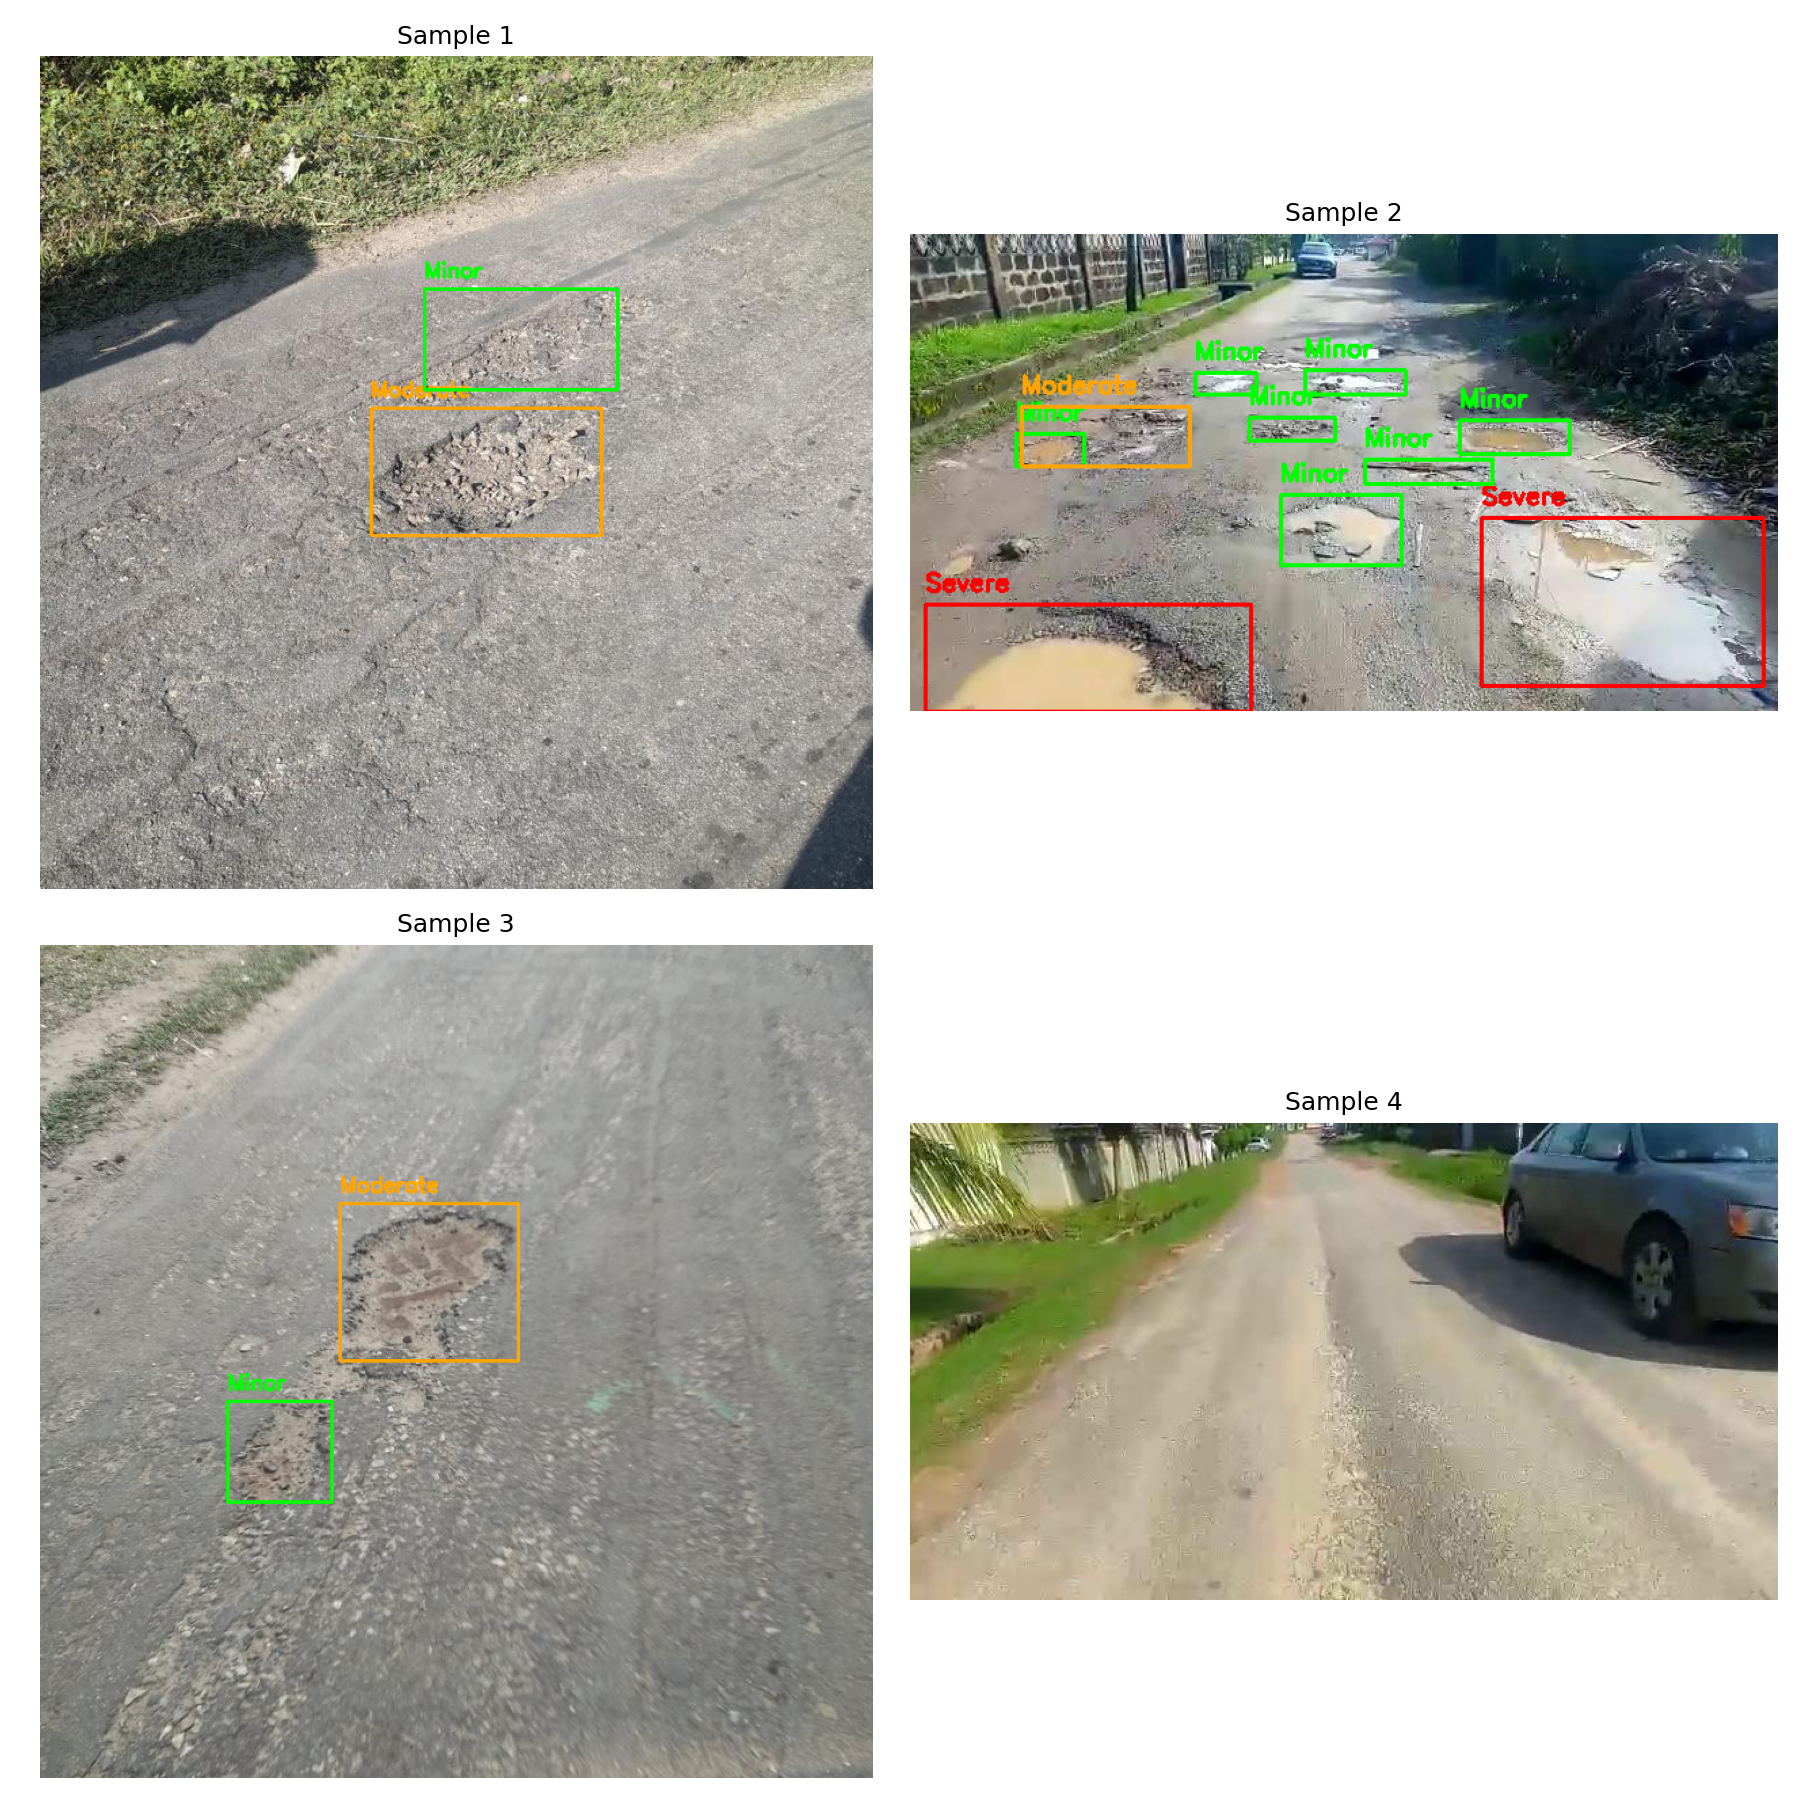


Inference Results:
✓ Green boxes = Minor severity potholes
✓ Orange boxes = Moderate severity potholes
✓ Red boxes = Severe severity potholes


In [16]:
# Display the saved inference examples
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import Image as IPImage, display

inference_name = 'inference_examples.png'
inference_path = f'runs/detect/{detection_model_name}/{inference_name}'

# Display using IPython Image (better for notebooks)
display(IPImage(filename=inference_path))

print("\nInference Results:")
print("✓ Green boxes = Minor severity potholes")
print("✓ Orange boxes = Moderate severity potholes") 
print("✓ Red boxes = Severe severity potholes")